# This Notebook will include graphical analysis of Amazon review data

Source:

Justifying recommendations using distantly-labeled reviews and fined-grained aspects.

Jianmo Ni, Jiacheng Li, Julian McAuley.

Empirical Methods in Natural Language Processing (EMNLP), 2019.

https://nijianmo.github.io/amazon/index.html

http://deepyeti.ucsd.edu/jianmo/amazon/index.html

------------------------------

Sentiment analysis code shall be later on transfered to .py files for easy execution

---------------

# Data Transformation

## Import Libraries

In [ ]:
import pandas as pd
import numpy as np

import os

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import math
from scipy.spatial import distance
from sklearn.metrics import accuracy_score
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras import layers

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import keras
import json
import os

# custom files
from neural_network import prepare_data, build_model, train_model, evaluate_model, plot_training_progress, model_predict, prepare_nn_input
from word_vectorization import create_tf_vector_all_reviews, create_idf_dictionary, create_word_vector_dict, create_input_word_vector
from data_transformation import get_overview, clean_data, balancing
from knn import knn

Using TensorFlow backend.


--------

## Import Data

In [22]:
# get all files to load

path = "./data"
files = os.listdir(path)
files = [element for element in files if not "FULL" in element]

In [23]:
# load first dataset
data = pd.read_json(path+"/"+files[0], lines = True)

# load other datasets
for i in range(1, len(files)):
    
    tmp_data = pd.read_json(path+"/"+files[i], lines = True)
    data = data.append(tmp_data)

In [2]:
# read subset data
#path = "./data/AMAZON_FASHION_5.json"

# read full data
path = "./data/AMAZON_FASHION_FULL.json"

data = pd.read_json(path, lines = True)

-------

# Data overview

In [3]:
get_overview(data)

Data has 883636 datapoints.
Data has 12 columns.
Columns: dtype
{'overall': 'int64', 'verified': 'bool', 'reviewTime': 'object', 'reviewerID': 'object', 'asin': 'object', 'reviewerName': 'object', 'reviewText': 'object', 'summary': 'object', 'unixReviewTime': 'int64', 'vote': 'float64', 'style': 'object', 'image': 'object'}


--------

## Data Cleaning

In [4]:
keepColumns = ["overall", "reviewText"]
data = clean_data(data, keepColumns)

Dropped 10 columns.
Droppend 1233 null values.
Data contains now 882403 datapoints.


-------

## Balancing

Most saved rating is 5 with 464591 datapoints.
Least saved rating is 2 with 64690 datapoints.


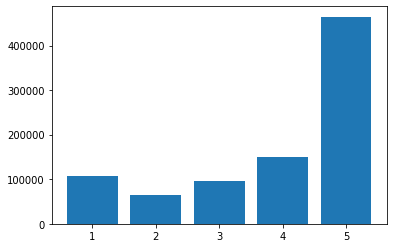

Dataset now contains 10000 datapoints.


In [5]:
max_num = 2000 # replace lateron
data = balancing(data, balancing = True, max_num = max_num)

Most saved rating is 1 with 2000 datapoints.
Least saved rating is 1 with 2000 datapoints.


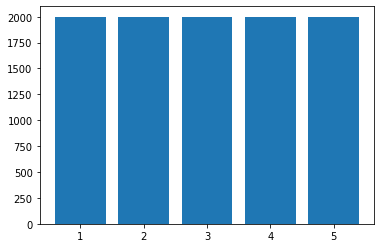

In [6]:
# check balancing
balancing(data, balancing = False, max_num = None)

-------

## Word Vectors

In [7]:
def save_dict_to_json(dic, filename):
    
    # append .json
    filename += ".json"
    
    f = open(filename, "w")
    json.dump(dic, f)
    f.close()

def load_dict_from_json(filename):
    
    # append .json
    filename += ".json"
    
    f = open(filename, "r")
    dic = json.loads(f.read())
    f.close()
    
    return dic

In [8]:
# create review_dict
review_dict = create_tf_vector_all_reviews(data)
#save_dict_to_json(review_dict, "review_dict")

# create idf dict
idf_dict = create_idf_dictionary(review_dict)
#save_dict_to_json(idf_dict, "idf_dict")

# create word_vec_dict
word_vec_dict = create_word_vector_dict(review_dict, idf_dict) # speed = 0.2 seconds per datapoint
#np.save('word_vec_dict.npy', word_vec_dict)

# include word_vec_dict in dataframe
data["word_vectors"] = list(word_vec_dict.values())

In [11]:
# alternative without processing word vectors
#word_vec_dict = np.load('word_vec_dict.npy', allow_pickle=True)[()]
#data["word_vectors"] = word_vec_dict.values()
#data.to_json("data_with_word_vectors.json")
#data = pd.read_json("data_with_word_vectors.json")

In [9]:
# get a look at the data
data.head()

,overall,reviewText,word_vectors
0,2,"I agree with the other review, the opening is ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,2,too tiny an opening,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,2,I smoke 100's and these are NOT made for them....,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,2,"It's ok, It doesn't close if you have 100's","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,2,Is very small. Doesn't fit my smokes...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


------

## Train Test Split

In [12]:
# create test and training dataset
test_size = 0.2
train_data, test_data = train_test_split(data,
                                         test_size = test_size,
                                         shuffle=True,
                                         stratify = data["overall"]
                                        )

train_data = train_data.reset_index(drop = True)
test_data = test_data.reset_index(drop = True)

In [13]:
# drop data dataframe
data = 0

-------

# Now start Sentiment analysis

-------

## knn

In [ ]:
import numpy as np

In [18]:
# test single n

# init variables
data_point = test_data[:1]
data_point_class = int(data_point["overall"])
data_point = np.asarray(data_point["word_vectors"].to_list())
n = 3

# calc class
calc_class = knn(train_data, data_point, n)

print(f"Test Datapoint has class: {calc_class}")
print(f"Original class was {data_point_class}")

Test Datapoint has class: 3
Original class was 3


In [19]:
# test multiple n

# init variables
data_point = test_data[:1]
data_point_class = int(data_point["overall"])
data_point = np.asarray(data_point["word_vectors"].to_list())
n = [1,2,3,4,5]

# calc class
calc_class = knn(train_data, data_point, n)

print(f"Test Datapoint has class: {calc_class}")
print(f"Original class was {data_point_class}")

Test Datapoint has class: {1: 3, 2: 3, 3: 3, 4: 3, 5: 3}
Original class was 3


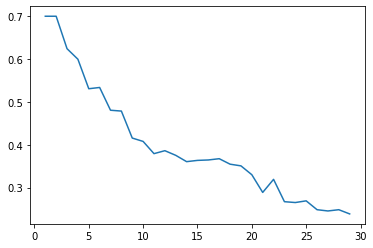

In [20]:
# test accuracy of combined dataset

# get test data
test_vectors = test_data["word_vectors"].to_list()
test_classes = test_data["overall"].to_list()

# init variables
pred_class = []
n_test = list(range(1,30))

# get classes
count = 0
for t_vector in test_vectors:

    pred_class.append(knn(train_data, np.asarray(t_vector), n_test))
    
    count += 1
    if (count % 100) == 0:
        
        print(f"Step {count}")
    
# init accuracy dict
acc_dict = {}

for sub_n in n_test:
    
    sub_n_val_classes = []
    
    for test_el in pred_class:
        
        sub_n_val_classes.append(test_el[sub_n])
    
    # get accuracy of sub_n
    accuracy = accuracy_score(test_classes, sub_n_val_classes)
    acc_dict[sub_n] = accuracy

# visualize
plt.plot(list(acc_dict.keys()), list(acc_dict.values()))
plt.show()

Step 100
Step 200
Step 300
Step 400
Step 500
Step 600
Step 700
Step 800
Step 900
Step 1000
Step 1100
Step 1200
Step 1300
Step 1400
Step 1500
Step 1600
Step 1700
Step 1800
Step 1900
Step 2000


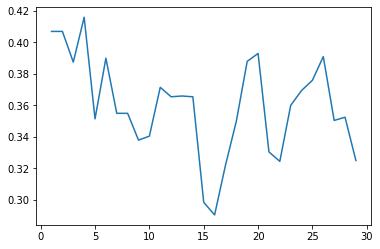

In [17]:
# test accuracy of full Amazon fashion

# get test data
test_vectors = test_data["word_vectors"].to_list()
test_classes = test_data["overall"].to_list()

# init variables
pred_class = []
n_test = list(range(1,30))

# get classes
count = 0
for t_vector in test_vectors:

    pred_class.append(knn(train_data, np.asarray(t_vector), n_test))
    
    count += 1
    if (count % 100) == 0:
        
        print(f"Step {count}")
    
# init accuracy dict
acc_dict = {}

for sub_n in n_test:
    
    sub_n_val_classes = []
    
    for test_el in pred_class:
        
        sub_n_val_classes.append(test_el[sub_n])
    
    # get accuracy of sub_n
    accuracy = accuracy_score(test_classes, sub_n_val_classes)
    acc_dict[sub_n] = accuracy

# visualize
plt.plot(list(acc_dict.keys()), list(acc_dict.values()))
plt.show()

----------

# Neural Network

## train model

Started training.
Finished training.
1018/1018 [==============================] - 0s 20us/step
Model has a loss of 0.8857659254889123 and an accuracy of 0.6925343871116638


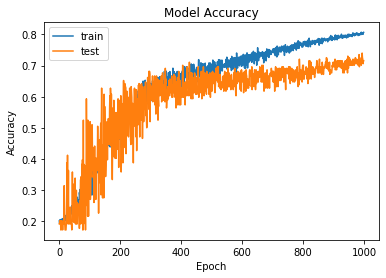

In [15]:
# get train, test and val data
x_train, y_train, x_val, y_val, x_test, y_test, shape = prepare_data(train_data, test_data)

# build model
model = build_model(shape, neuron_layers = 1, neuron_count = [20], activation_functions = ["sigmoid"])

# train model
model, history = train_model(model, x_train, y_train, x_val, y_val, 
                             epochs= 1000, batch_size = 64, show_output = False)

# print model evaluation
results = evaluate_model(model, x_test, y_test)
print(f"Model has a loss of {results[0]} and an accuracy of {results[1]}")

# plot training progress
plot_training_progress(history)

# save model
model.save("amazonreviews")

--------

## NN Predict on user Data

In [49]:
# load model and idf_dict
model = keras.models.load_model("amazonreviews")
idf_dict = load_dict_from_json("idf_dict")

In [51]:
# get user input
input_string = input("Please enter your Product review: ")

# process string to word vector
word_vec = create_input_word_vector(input_string, idf_dict) # also usable for knn
input_vector = prepare_nn_input(word_vec, shape)

# predict review score
review_score = model_predict(input_vector, model)

# print user output
print(f"Your score is most likly: {review_score}")

Please enter your Product review: Terrible. Hate it
Your score is most likly: 1


In [22]:
# get user input
input_string = input("Please enter your Product review: ")

# process string to word vector
word_vec = create_input_word_vector(input_string, idf_dict) # also usable for knn
input_vector = prepare_nn_input(word_vec, shape)

# predict review score
review_score = model_predict(input_vector, model)

# print user output
print(f"Your score is most likly: {review_score}")

Please enter your Product review: Great Product. love it buy again
Your score is most likly: 5


In [52]:
# get user input
input_string = input("Please enter your Product review: ")

# process string to word vector
word_vec = create_input_word_vector(input_string, idf_dict) # also usable for knn
input_vector = prepare_nn_input(word_vec, shape)

# predict review score
review_score = model_predict(input_vector, model2)

# print user output
print(f"Your score is most likly: {review_score}")

Please enter your Product review: Its ok. there are good and bad points
Your score is most likly: 4


--------

## Test different model configurations

### newer tests

In [ ]:
# get train, test and val data
x_train, y_train, x_val, y_val, x_test, y_test, shape = prepare_data(train_data, test_data)

# build model
model = build_model(shape, neuron_layers = 2, neuron_count = [20, 10], activation_functions = ["sigmoid", "relu"])

# train model
model, history = train_model(model, x_train, y_train, x_val, y_val, 
                             epochs= 1000, batch_size = 64, show_output = False)

# print model evaluation
results = evaluate_model(model, x_test, y_test)
print(f"Model has a loss of {results[0]} and an accuracy of {results[1]}")

# plot training progress
plot_training_progress(history)

### older tests

Fit model on training data
Model Data with, epoch count of 1000, 
                      second layer = True, neuron number of 5,
                      and an sigmoid main activation function


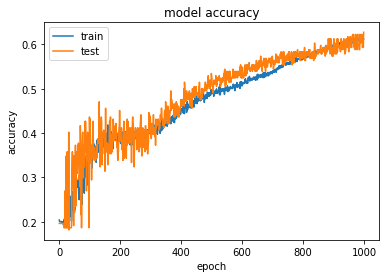

1018/1018 [==============================] - 0s 18us/step
test loss, test acc: [1.0605342650460354, 0.5609037280082703]
----------------------------------------------------------------------------------------------------
Fit model on training data
Model Data with, epoch count of 1000, 
                      second layer = True, neuron number of 5,
                      and an relu main activation function


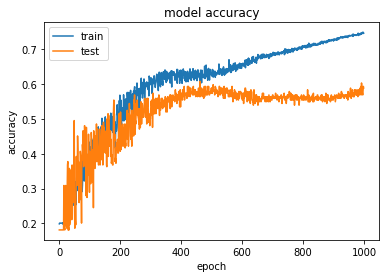

1018/1018 [==============================] - 0s 17us/step
test loss, test acc: [0.9132947702773193, 0.6178781986236572]
----------------------------------------------------------------------------------------------------
Fit model on training data
Model Data with, epoch count of 1000, 
                      second layer = True, neuron number of 10,
                      and an sigmoid main activation function


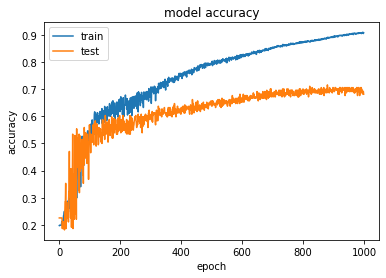

1018/1018 [==============================] - 0s 18us/step
test loss, test acc: [0.6991537325742905, 0.7524557709693909]
----------------------------------------------------------------------------------------------------
Fit model on training data
Model Data with, epoch count of 1000, 
                      second layer = True, neuron number of 10,
                      and an relu main activation function


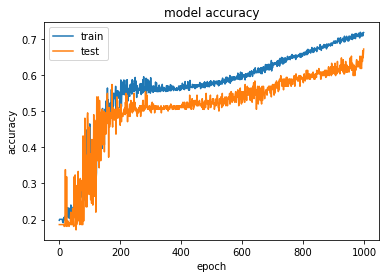

1018/1018 [==============================] - 0s 24us/step
test loss, test acc: [0.9494688950025263, 0.6404715180397034]
----------------------------------------------------------------------------------------------------
Fit model on training data
Model Data with, epoch count of 1000, 
                      second layer = True, neuron number of 20,
                      and an sigmoid main activation function


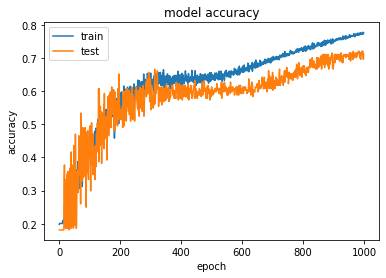

1018/1018 [==============================] - 0s 24us/step
test loss, test acc: [0.863985970001558, 0.6777995824813843]
----------------------------------------------------------------------------------------------------
Fit model on training data
Model Data with, epoch count of 1000, 
                      second layer = True, neuron number of 20,
                      and an relu main activation function


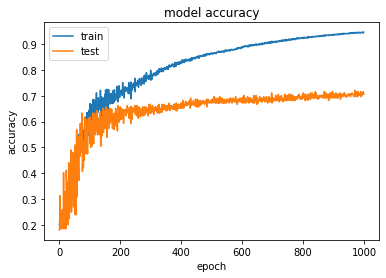

1018/1018 [==============================] - 0s 19us/step
test loss, test acc: [0.6784178030280092, 0.7534381151199341]
----------------------------------------------------------------------------------------------------
Fit model on training data
Model Data with, epoch count of 1000, 
                      second layer = False, neuron number of 5,
                      and an sigmoid main activation function


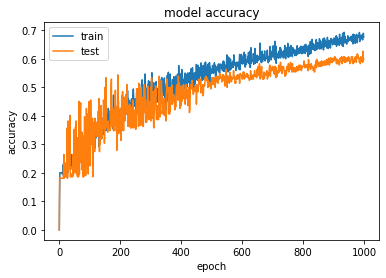

1018/1018 [==============================] - 0s 20us/step
test loss, test acc: [1.1259713334512618, 0.6110019683837891]
----------------------------------------------------------------------------------------------------
Fit model on training data
Model Data with, epoch count of 1000, 
                      second layer = False, neuron number of 5,
                      and an relu main activation function


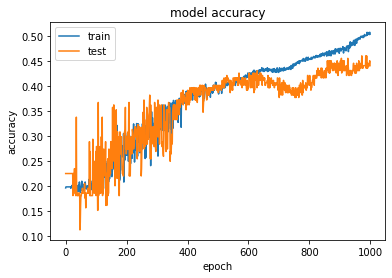

1018/1018 [==============================] - 0s 22us/step
test loss, test acc: [1.1758442962567792, 0.4626719057559967]
----------------------------------------------------------------------------------------------------
Fit model on training data
Model Data with, epoch count of 1000, 
                      second layer = False, neuron number of 10,
                      and an sigmoid main activation function


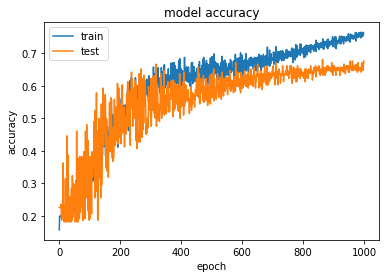

1018/1018 [==============================] - 0s 34us/step
test loss, test acc: [0.9997822439740823, 0.6719056963920593]
----------------------------------------------------------------------------------------------------
Fit model on training data
Model Data with, epoch count of 1000, 
                      second layer = False, neuron number of 10,
                      and an relu main activation function


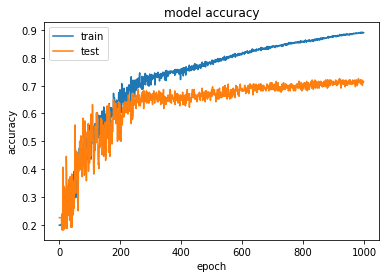

1018/1018 [==============================] - 0s 19us/step
test loss, test acc: [0.7291900711115779, 0.7396856546401978]
----------------------------------------------------------------------------------------------------
Fit model on training data
Model Data with, epoch count of 1000, 
                      second layer = False, neuron number of 20,
                      and an sigmoid main activation function


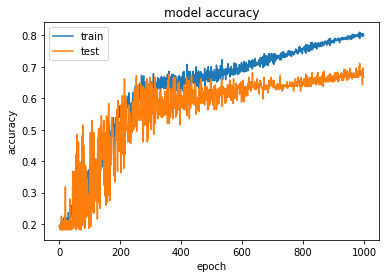

1018/1018 [==============================] - 0s 18us/step
test loss, test acc: [0.8916117187099044, 0.7072691321372986]
----------------------------------------------------------------------------------------------------
Fit model on training data
Model Data with, epoch count of 1000, 
                      second layer = False, neuron number of 20,
                      and an relu main activation function


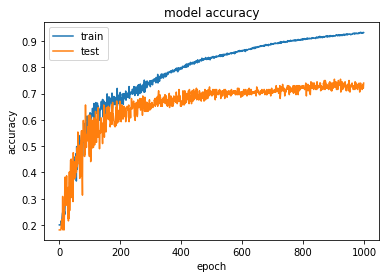

1018/1018 [==============================] - 0s 20us/step
test loss, test acc: [0.6940813216807098, 0.7426326274871826]
----------------------------------------------------------------------------------------------------
Fit model on training data
Model Data with, epoch count of 3000, 
                      second layer = True, neuron number of 5,
                      and an sigmoid main activation function


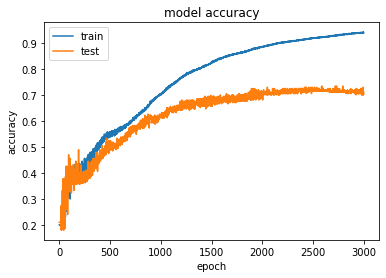

1018/1018 [==============================] - 0s 20us/step
test loss, test acc: [0.8966188813707917, 0.7387033104896545]
----------------------------------------------------------------------------------------------------
Fit model on training data
Model Data with, epoch count of 3000, 
                      second layer = True, neuron number of 5,
                      and an relu main activation function


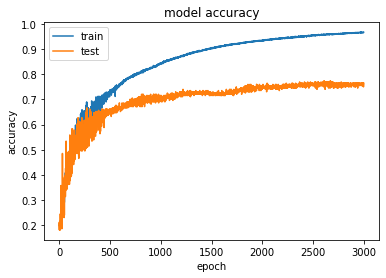

1018/1018 [==============================] - 0s 23us/step
test loss, test acc: [0.8911164929918315, 0.7485265135765076]
----------------------------------------------------------------------------------------------------
Fit model on training data
Model Data with, epoch count of 3000, 
                      second layer = True, neuron number of 10,
                      and an sigmoid main activation function


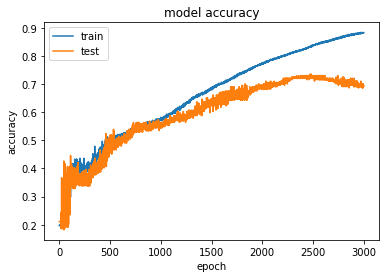

1018/1018 [==============================] - 0s 17us/step
test loss, test acc: [0.7898379283241767, 0.7278978228569031]
----------------------------------------------------------------------------------------------------
Fit model on training data
Model Data with, epoch count of 3000, 
                      second layer = True, neuron number of 10,
                      and an relu main activation function


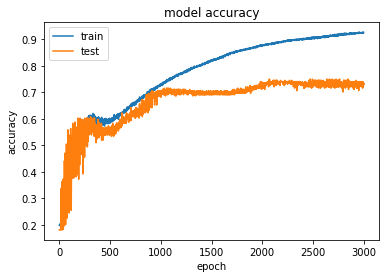

1018/1018 [==============================] - 0s 20us/step
test loss, test acc: [0.8475107750864534, 0.7278978228569031]
----------------------------------------------------------------------------------------------------
Fit model on training data
Model Data with, epoch count of 3000, 
                      second layer = True, neuron number of 20,
                      and an sigmoid main activation function


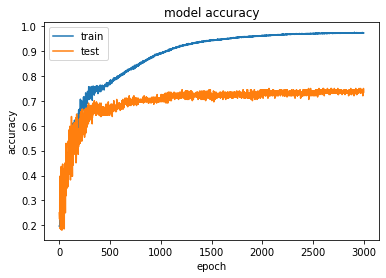

1018/1018 [==============================] - 0s 19us/step
test loss, test acc: [0.9223631476372305, 0.7583497166633606]
----------------------------------------------------------------------------------------------------
Fit model on training data
Model Data with, epoch count of 3000, 
                      second layer = True, neuron number of 20,
                      and an relu main activation function


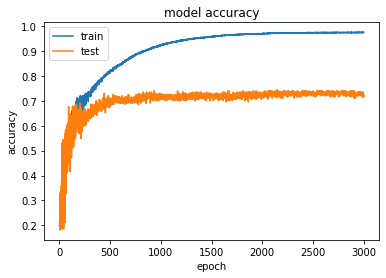

1018/1018 [==============================] - 0s 21us/step
test loss, test acc: [1.0131137100558851, 0.7583497166633606]
----------------------------------------------------------------------------------------------------
Fit model on training data
Model Data with, epoch count of 3000, 
                      second layer = False, neuron number of 5,
                      and an sigmoid main activation function


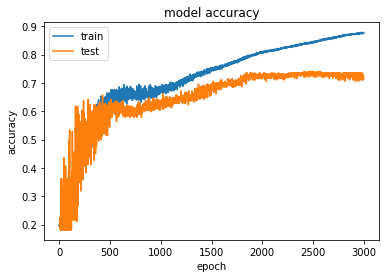

1018/1018 [==============================] - 0s 19us/step
test loss, test acc: [0.7509782258091835, 0.7259331941604614]
----------------------------------------------------------------------------------------------------
Fit model on training data
Model Data with, epoch count of 3000, 
                      second layer = False, neuron number of 5,
                      and an relu main activation function


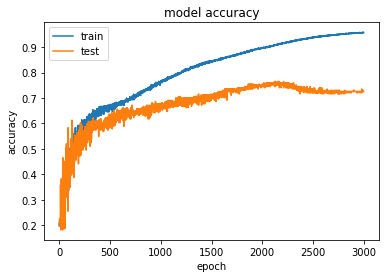

1018/1018 [==============================] - 0s 18us/step
test loss, test acc: [0.8205998383008661, 0.7554027438163757]
----------------------------------------------------------------------------------------------------
Fit model on training data
Model Data with, epoch count of 3000, 
                      second layer = False, neuron number of 10,
                      and an sigmoid main activation function


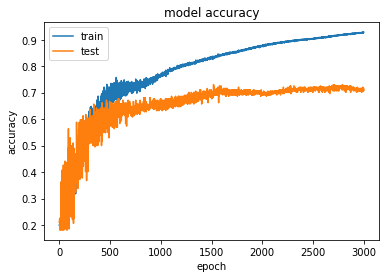

1018/1018 [==============================] - 0s 20us/step
test loss, test acc: [0.6963717452669425, 0.7554027438163757]
----------------------------------------------------------------------------------------------------
Fit model on training data
Model Data with, epoch count of 3000, 
                      second layer = False, neuron number of 10,
                      and an relu main activation function


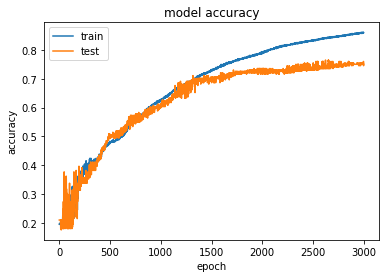

1018/1018 [==============================] - 0s 18us/step
test loss, test acc: [0.9230683423681203, 0.6777995824813843]
----------------------------------------------------------------------------------------------------
Fit model on training data
Model Data with, epoch count of 3000, 
                      second layer = False, neuron number of 20,
                      and an sigmoid main activation function


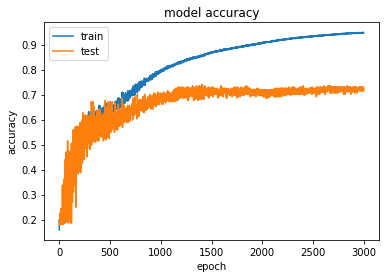

1018/1018 [==============================] - 0s 25us/step
test loss, test acc: [0.6843019648947275, 0.7632613182067871]
----------------------------------------------------------------------------------------------------
Fit model on training data
Model Data with, epoch count of 3000, 
                      second layer = False, neuron number of 20,
                      and an relu main activation function


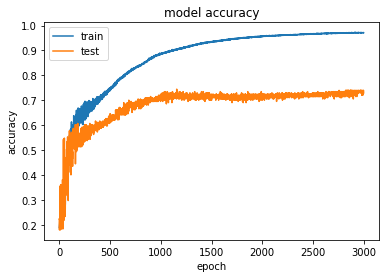

1018/1018 [==============================] - 0s 18us/step
test loss, test acc: [0.89550499702952, 0.7524557709693909]
----------------------------------------------------------------------------------------------------


In [78]:
neuron_count = [5, 10, 20]
second_layer = [True, False]
epochs = [1000, 3000]
main_activation = ["sigmoid", "relu"]

for epoch_count in epochs:

    for second_layer_active in second_layer:
        
        for neuron_number in neuron_count:
            
            for activation in main_activation:

                inputs = keras.Input(shape=(shape,), name="wordvecors")
                x = layers.Dense(neuron_number, activation=activation, name="dense_1")(inputs)

                if second_layer_active:
                    x = layers.Dense(neuron_number, activation="relu", name="dense_1")(inputs)

                outputs = layers.Dense(10, activation="softmax", name="predictions")(x)

                model = keras.Model(inputs=inputs, outputs=outputs)

                model.compile(
                    optimizer=keras.optimizers.RMSprop(),  # Optimizer
                    # Loss function to minimize
                    loss=keras.losses.SparseCategoricalCrossentropy(),
                    # List of metrics to monitor
                    metrics=[keras.metrics.SparseCategoricalAccuracy()],
                )

                print("Fit model on training data")
                history = model.fit(
                    x_train,
                    y_train,
                    batch_size=64,
                    epochs=epoch_count,
                    verbose = 0, # not output
                    validation_data=(x_val, y_val),
                )
                print(f"""Model Data with, epoch count of {epoch_count}, 
                      second layer = {second_layer_active}, neuron number of {neuron_number},
                      and an {activation} main activation function""")
                plt.plot(history.history['sparse_categorical_accuracy'])
                plt.plot(history.history['val_sparse_categorical_accuracy'])
                plt.title('model accuracy')
                plt.ylabel('accuracy')
                plt.xlabel('epoch')
                plt.legend(['train', 'test'], loc='upper left')
                plt.show()
                
                results = model.evaluate(x_test, y_test, batch_size=128)
                print("test loss, test acc:", results)
                
                print(100*"-")

Fit model on training data
Model Data with, epoch count of 1000, 
                      second layer = True, neuron number of 5,
                      and an sigmoid main activation function


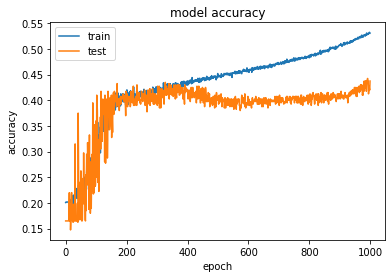

2000/2000 [==============================] - 0s 99us/step
test loss, test acc: [1.2387893695831298, 0.45100000500679016]
----------------------------------------------------------------------------------------------------
Fit model on training data
Model Data with, epoch count of 1000, 
                      second layer = True, neuron number of 5,
                      and an relu main activation function


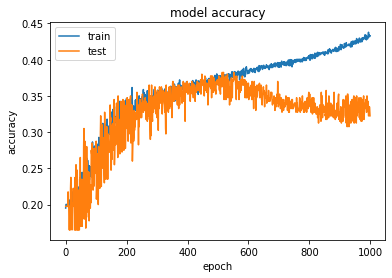

2000/2000 [==============================] - 0s 15us/step
test loss, test acc: [1.509524118423462, 0.33000001311302185]
----------------------------------------------------------------------------------------------------
Fit model on training data
Model Data with, epoch count of 1000, 
                      second layer = True, neuron number of 10,
                      and an sigmoid main activation function


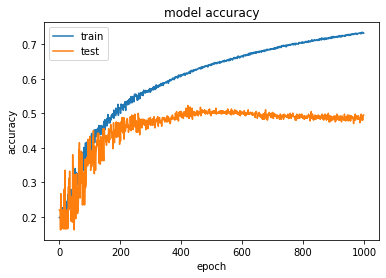

2000/2000 [==============================] - 0s 21us/step
test loss, test acc: [1.2424069805145264, 0.534500002861023]
----------------------------------------------------------------------------------------------------
Fit model on training data
Model Data with, epoch count of 1000, 
                      second layer = True, neuron number of 10,
                      and an relu main activation function


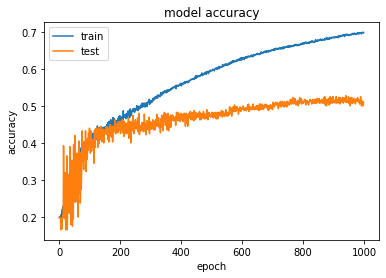

2000/2000 [==============================] - 2s 905us/step
test loss, test acc: [1.210746542930603, 0.5180000066757202]
----------------------------------------------------------------------------------------------------
Fit model on training data
Model Data with, epoch count of 1000, 
                      second layer = True, neuron number of 20,
                      and an sigmoid main activation function


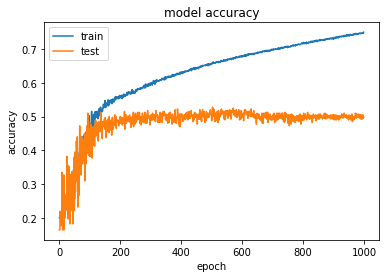

2000/2000 [==============================] - 0s 11us/step
test loss, test acc: [1.2385325870513917, 0.5440000295639038]
----------------------------------------------------------------------------------------------------
Fit model on training data
Model Data with, epoch count of 1000, 
                      second layer = True, neuron number of 20,
                      and an relu main activation function


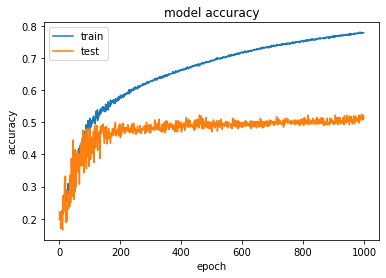

2000/2000 [==============================] - 0s 19us/step
test loss, test acc: [1.290763186454773, 0.5475000143051147]
----------------------------------------------------------------------------------------------------
Fit model on training data
Model Data with, epoch count of 1000, 
                      second layer = False, neuron number of 5,
                      and an sigmoid main activation function


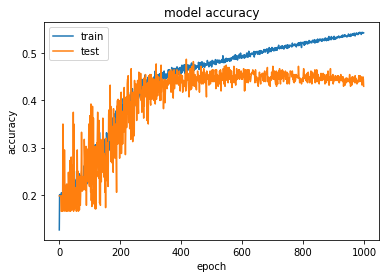

2000/2000 [==============================] - 0s 11us/step
test loss, test acc: [1.2637388706207275, 0.46299999952316284]
----------------------------------------------------------------------------------------------------
Fit model on training data
Model Data with, epoch count of 1000, 
                      second layer = False, neuron number of 5,
                      and an relu main activation function


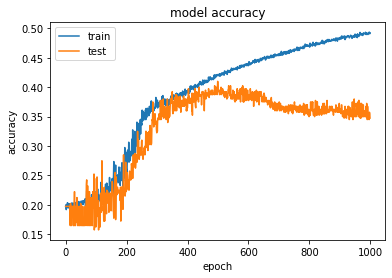

2000/2000 [==============================] - 0s 20us/step
test loss, test acc: [1.2808194189071656, 0.41499999165534973]
----------------------------------------------------------------------------------------------------
Fit model on training data
Model Data with, epoch count of 1000, 
                      second layer = False, neuron number of 10,
                      and an sigmoid main activation function


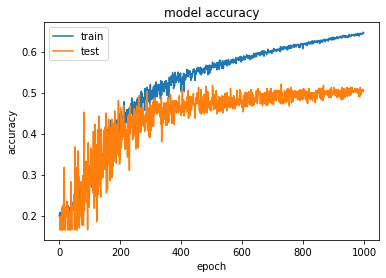

2000/2000 [==============================] - 0s 19us/step
test loss, test acc: [1.2050222911834716, 0.5164999961853027]
----------------------------------------------------------------------------------------------------
Fit model on training data
Model Data with, epoch count of 1000, 
                      second layer = False, neuron number of 10,
                      and an relu main activation function


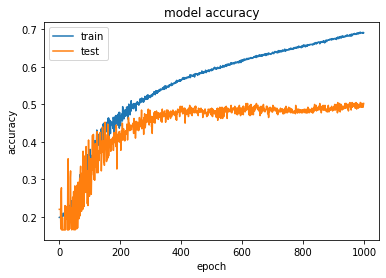

2000/2000 [==============================] - 0s 10us/step
test loss, test acc: [1.2118401889801025, 0.5235000252723694]
----------------------------------------------------------------------------------------------------
Fit model on training data


KeyboardInterrupt: 

In [13]:
# Test with full dataset
neuron_count = [5, 10, 20]
second_layer = [True, False]
epochs = [1000, 3000]
main_activation = ["sigmoid", "relu"]

for epoch_count in epochs:

    for second_layer_active in second_layer:
        
        for neuron_number in neuron_count:
            
            for activation in main_activation:

                inputs = keras.Input(shape=(shape,), name="wordvecors")
                x = layers.Dense(neuron_number, activation=activation, name="dense_1")(inputs)

                if second_layer_active:
                    x = layers.Dense(neuron_number, activation="relu", name="dense_1")(inputs)

                outputs = layers.Dense(10, activation="softmax", name="predictions")(x)

                model = keras.Model(inputs=inputs, outputs=outputs)

                model.compile(
                    optimizer=keras.optimizers.RMSprop(),  # Optimizer
                    # Loss function to minimize
                    loss=keras.losses.SparseCategoricalCrossentropy(),
                    # List of metrics to monitor
                    metrics=[keras.metrics.SparseCategoricalAccuracy()],
                )

                print("Fit model on training data")
                history = model.fit(
                    x_train,
                    y_train,
                    batch_size=64,
                    epochs=epoch_count,
                    verbose = 0, # not output
                    validation_data=(x_val, y_val),
                )
                print(f"""Model Data with, epoch count of {epoch_count}, 
                      second layer = {second_layer_active}, neuron number of {neuron_number},
                      and an {activation} main activation function""")
                plt.plot(history.history['sparse_categorical_accuracy'])
                plt.plot(history.history['val_sparse_categorical_accuracy'])
                plt.title('model accuracy')
                plt.ylabel('accuracy')
                plt.xlabel('epoch')
                plt.legend(['train', 'test'], loc='upper left')
                plt.show()
                
                results = model.evaluate(x_test, y_test, batch_size=128)
                print("test loss, test acc:", results)
                
                print(100*"-")